In [1]:
import numpy as np
import pickle
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr, spearmanr
import nibabel as nib
from scipy.stats import zscore
from scipy.stats import linregress
import matplotlib.pyplot as plt

# import hippocampo-cortical and cortico-cortical FC
with open('_DATA/hippocampo_cortical_FC.pkl', 'rb') as f:
    hc_FC = pickle.load(f)[1] # use only scheafer 200 atlas (index 1)
cc_FC = np.load('_DATA/cortico_cortical_FC_without_hippocampus.npy')
print(hc_FC.shape) #(65, 200, 3), 3 is for moments used (all, post-event boundary, sequencing)
print(cc_FC.shape) #(65, 19900, 3)

content_score = np.load("_DATA/content_score.npy")
ordering_score = np.load("_DATA/ordering_score.npy")

(65, 200, 3)
(65, 19900, 3)


In [ ]:
import time
from multiprocessing import Pool
selection_threshold = 0.05
def get_LOO_prediction(test_idx):
    test_sub = np.eye(65)[test_idx]==1
    train_subs =  np.eye(65)[test_idx]==0
    positive_edges = []
    negative_edges = []
    for edge in range(num_edges):
        brain_vector = FC[train_subs, edge]
        behav_vector = behavioral_score[train_subs]
        r, p = pearsonr(brain_vector, behav_vector)
        if p < selection_threshold:
            if r >= 0:
                positive_edges.append(edge)
            elif r < 0:
                negative_edges.append(edge)
    positive_edges = np.array(positive_edges)
    negative_edges = np.array(negative_edges)
    if len(positive_edges)>0:
        positive_train = np.sum(FC[train_subs,:][:,positive_edges], axis=1)
        positive_test = np.sum(FC[test_sub,:][:,positive_edges], axis=1)
    else:
        positive_train = np.zeros(64)
        positive_test = np.zeros(1)
    if len(negative_edges)>0:
        negative_train = np.sum(FC[train_subs,:][:,negative_edges], axis=1)
        negative_test = np.sum(FC[test_sub,:][:,negative_edges], axis=1)
    else:
        negative_train = np.zeros(64)
        negative_test = np.zeros(1)
    X_train = np.vstack([positive_train, negative_train]).T
    X_test = np.vstack([positive_test, negative_test]).T
    y_train = behavioral_score[train_subs]
    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(X_test)[0]
    return y_pred


In [ ]:
# For cortico-cortical FC model without the hippocampus
# Important note: This code takes a long time to run.
# In a workstation with 32 cores, approximately it took about 4 days (>100 hours) to run.

save=False
if save:
    n_subjects = 65
    n_iteration = 500
    n_rois_list = np.arange(0, 200, 10)
    model_predictivity = np.zeros((len(n_rois_list), 2, n_iteration))
    print(n_rois_list)
    time_sta = time.time()
    for e, n_rois in enumerate(n_rois_list): # lesioned ROIs
        print(f'*******************************************')
        for b, behavioral_score in enumerate([ordering_score, content_score]):
            if b == 0:
                t = 2 # sequencing moments are used for ordering score
            elif b == 1:
                t = 1 # post-event boundaries are used for content score
            np.random.seed(0)
            for i in range(n_iteration):
                if i%100 == 0:
                    print(f'n_edges: {n_rois}, iteration: {i}/{n_iteration}')
                random_mask = np.zeros((200,200))
                random_mask[np.tril_indices(200, k=-1)] = 1
                idx = np.random.permutation(200)[:int(n_rois)].astype(int)
                random_mask[idx,:] = 0
                random_mask[:,idx] = 0
                random_mask = random_mask[np.tril_indices(200, k=-1)]

                FC = cc_FC[:,random_mask==1,t]
                FC = np.arctanh(FC)
                num_edges = FC.shape[1]
                with Pool(32) as pool:
                    behavioral_prediction = pool.map(get_LOO_prediction, [i for i in np.arange(n_subjects)])
                r, p = pearsonr(behavioral_prediction, behavioral_score)
                model_predictivity[e, b, i] = r
                if e ==0:
                    model_predictivity[e, b, :] = r
                    break
    print(time.time() - time_sta)
    np.save('_DATA/continuous_lesion_predictivity_cortico_cortical_without_hippocampus.npy', model_predictivity)

In [ ]:
# For cortico-cortical FC model WITH the hippocampus
# Important note: This code takes a long time to run.
# In a workstation with 32 cores, approximately it took about 4 days (>100 hours) to run.

save=False
if save:
    n_subjects = 65
    n_iteration = 500
    n_rois_list = np.arange(0, 200, 10)
    model_predictivity = np.zeros((len(n_rois_list), 2, n_iteration))
    print(n_rois_list)
    time_sta = time.time()
    for e, n_rois in enumerate(n_rois_list): # lesioned ROIs
        print(f'*******************************************')
        for b, behavioral_score in enumerate([ordering_score, content_score]):
            if b == 0:
                t = 2 # sequencing moments are used for ordering score
            elif b == 1:
                t = 1 # post-event boundaries are used for content score
            np.random.seed(0)
            for i in range(n_iteration):
                if i%100 == 0:
                    print(f'n_edges: {n_rois}, iteration: {i}/{n_iteration}')
                random_mask = np.zeros((200,200))
                random_mask[np.tril_indices(200, k=-1)] = 1
                idx = np.random.permutation(200)[:int(n_rois)].astype(int)
                random_mask[idx,:] = 0
                random_mask[:,idx] = 0
                random_mask = random_mask[np.tril_indices(200, k=-1)]

                FC = cc_FC[:,random_mask==1,t]
                FC = np.hstack([FC, hc_FC[:,:,t]])
                FC = np.arctanh(FC)
                num_edges = FC.shape[1]
                with Pool(32) as pool:
                    behavioral_prediction = pool.map(get_LOO_prediction, [i for i in np.arange(n_subjects)])
                r, p = pearsonr(behavioral_prediction, behavioral_score)
                model_predictivity[e, b, i] = r
                if e ==0:
                    model_predictivity[e, b, :] = r
                    break
    print(time.time() - time_sta)
    np.save('_DATA/continuous_lesion_predictivity_cortico_cortical_with_hippocampus.npy', model_predictivity)

whole-brain PearsonRResult(statistic=-0.840163311148419, pvalue=3.5648962024930362e-06)
HPC PearsonRResult(statistic=-0.9212580044909454, pvalue=3.139616815924199e-09)
whole-brain PearsonRResult(statistic=0.6736385696828541, pvalue=0.001129303410430009)
HPC PearsonRResult(statistic=-0.9023514467227948, pvalue=2.2488216054961065e-08)


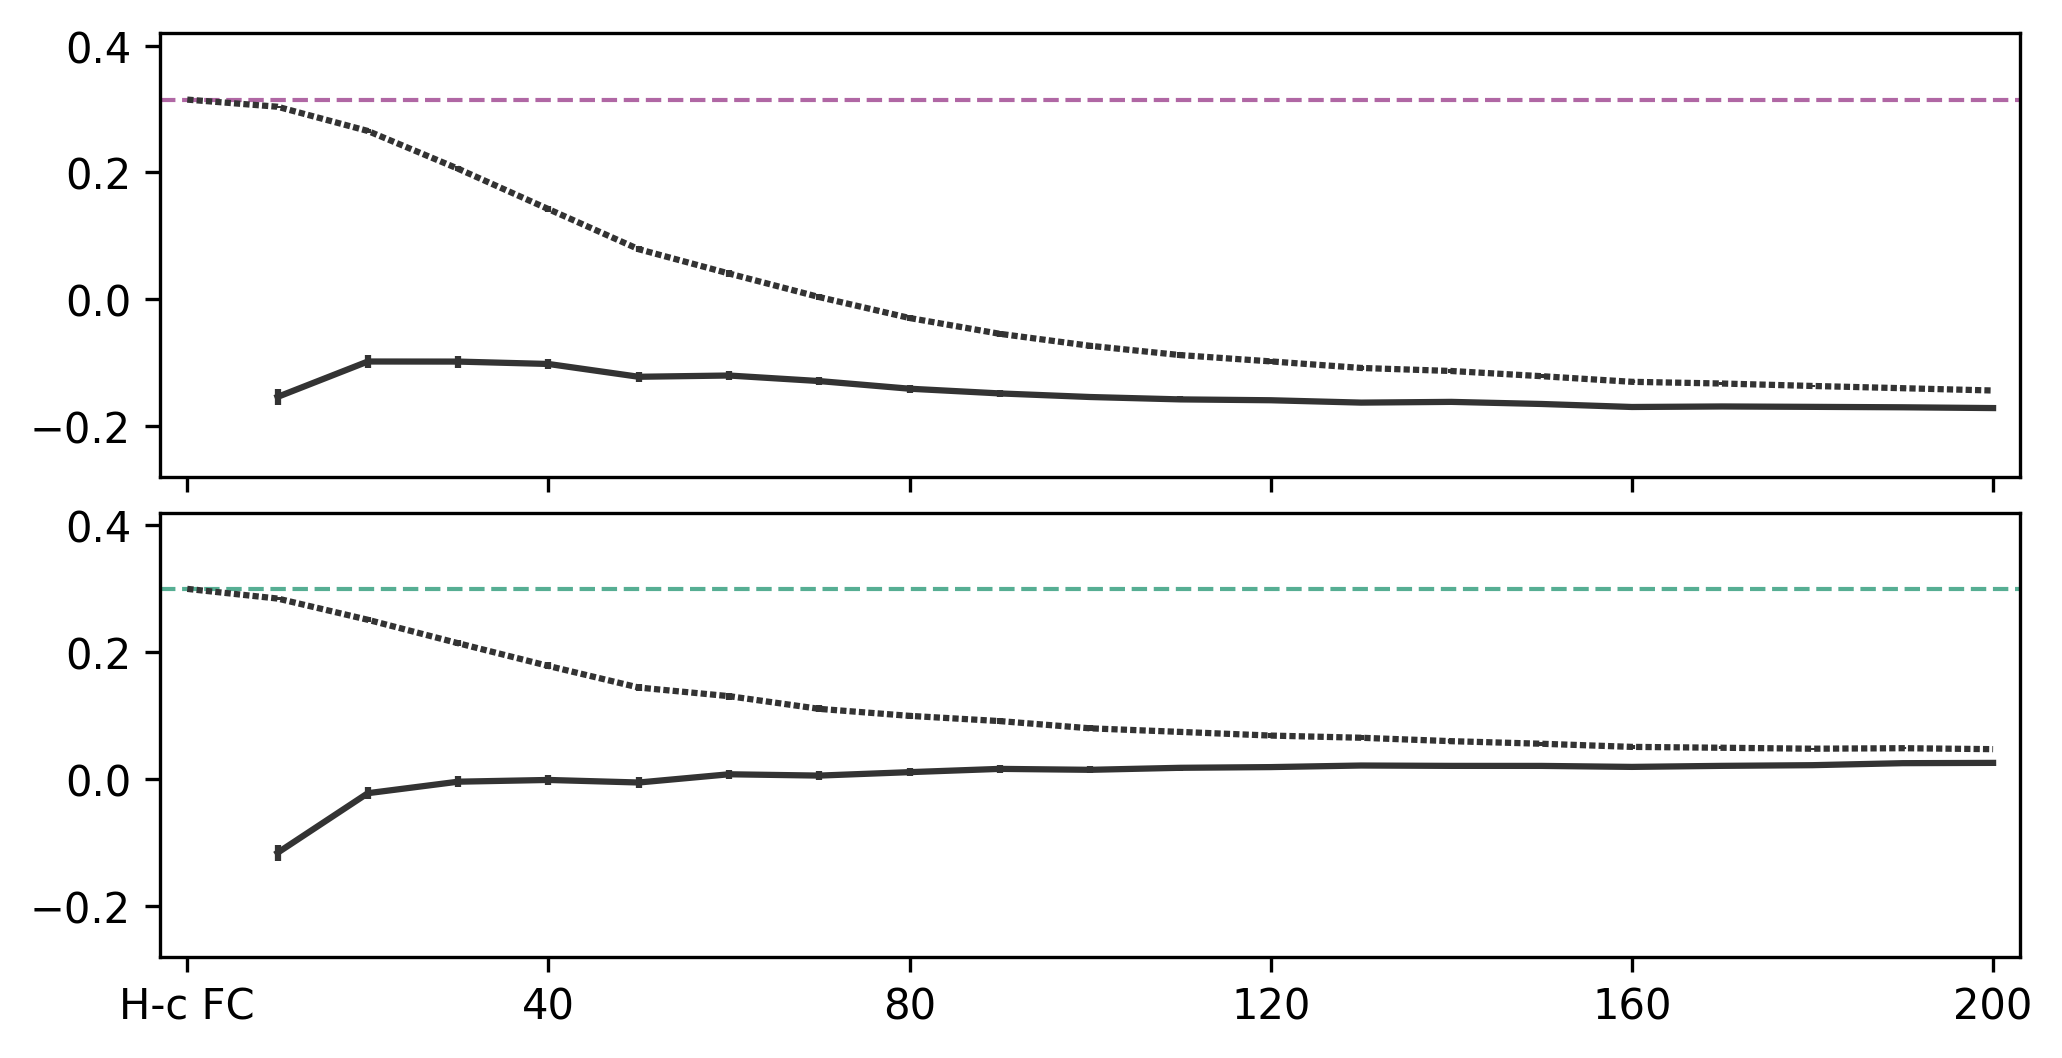

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem, pearsonr, spearmanr
plt.style.use('default')

n_iteration = 500
n_rois_list = np.arange(0, 200, 10)

model_predictivity_without_hippocampus = np.load('_DATA/continuous_lesion_predictivity_cortico_cortical_without_hippocampus.npy')
model_predictivity_with_hippocampus = np.load('_DATA/continuous_lesion_predictivity_cortico_cortical_with_hippocampus.npy')

fig, axes = plt.subplots(2,1,figsize=(8,4), dpi=300, sharex=True, sharey=True)
linecolor = '#333333'
hippocampal_predictivity = [0.3147941556116186, 0.2998089418135322] # original model predictivity with hippocampus
axes[0].axhline(0.3147941556116186, c='#B067A4', lw=1, linestyle='--')
axes[1].axhline(0.2998089418135322, c='#56AE93', lw=1, linestyle='--')


for b in range(2):
    predictivity_mean = np.mean(model_predictivity_without_hippocampus[:,b,:], axis=-1)[::-1]
    predictivity_sem = sem(model_predictivity_without_hippocampus[:,b,:], axis=-1)[::-1]
    print("whole-brain", pearsonr(np.arange(len(n_rois_list)), predictivity_mean))
    axes[b].errorbar(np.arange(len(n_rois_list))+1, predictivity_mean, yerr=predictivity_sem, c=linecolor, lw=1.5, label='None')

    predictivity_mean = np.mean(model_predictivity_with_hippocampus[:,b,:], axis=-1)[::-1]
    predictivity_sem = sem(model_predictivity_with_hippocampus[:,b,:], axis=-1)[::-1]

    predictivity_mean = np.hstack([hippocampal_predictivity[b], predictivity_mean])
    predictivity_sem = np.hstack([0.0, predictivity_sem])

    print("HPC", pearsonr(np.arange(len(n_rois_list)+1), predictivity_mean))
    axes[b].errorbar(np.arange(len(n_rois_list)+1), predictivity_mean, yerr=predictivity_sem,
                     linestyle=(0, (1, 0.5)), c=linecolor, lw=1.5, label='HPC')

axes[1].set_yticks([-0.2, 0.0, 0.2,0.4])
axes[1].set_ylim([-0.28, 0.42])
axes[1].set_xlim(-0.3, 20.3)
axes[1].set_xticks([0, 4,8,12,16,20])
axes[1].set_xticklabels(["H-c FC","40", "80", "120", "160", "200"])
plt.subplots_adjust(hspace=0.08)

In [5]:
# For supplementary figure S6B

# import both cortical and subcortical timeseries
# subcortical timeseries are extracted from the Brainnetome atlas
# 200 cortical area from scheafer atlas and 36 subcortical area from brainnetome atlas

n_subjects = 65
cortical_timeseries = np.load('_DATA/cortical_timeseries.npy', allow_pickle=True)
cortical_timeseries = np.copy(np.array([cortical_timeseries[i,1] for i in range(n_subjects)]))
subcortical_timeseries = np.load('_DATA/subcortical_timeseries.npy')
print(cortical_timeseries.shape) # (65, 610, 200)
print(subcortical_timeseries.shape) # (65, 610, 36)

# concatenate cortical and subcortical timeseries
seed_roi_timeseries = np.concatenate([cortical_timeseries, subcortical_timeseries], axis=-1)
print(seed_roi_timeseries.shape) # (65, 610, 236)

(65, 610, 200)
(65, 610, 36)
(65, 610, 236)


In [7]:
from multiprocessing import Pool
selection_threshold = 0.05
def get_LOO_prediction(test_idx):
    test_sub = np.eye(65)[test_idx]==1
    train_subs =  np.eye(65)[test_idx]==0
    positive_edges = []
    negative_edges = []
    for edge in range(num_edges):
        brain_vector = FC[train_subs, edge]
        behav_vector = behavioral_score[train_subs]
        r, p = pearsonr(brain_vector, behav_vector)
        if p < selection_threshold:
            if r >= 0:
                positive_edges.append(edge)
            elif r < 0:
                negative_edges.append(edge)
    positive_edges = np.array(positive_edges)
    negative_edges = np.array(negative_edges)
    if len(positive_edges)>0:
        positive_train = np.sum(FC[train_subs,:][:,positive_edges], axis=1)
        positive_test = np.sum(FC[test_sub,:][:,positive_edges], axis=1)
    else:
        positive_train = np.zeros(64)
        positive_test = np.zeros(1)
    if len(negative_edges)>0:
        negative_train = np.sum(FC[train_subs,:][:,negative_edges], axis=1)
        negative_test = np.sum(FC[test_sub,:][:,negative_edges], axis=1)
    else:
        negative_train = np.zeros(64)
        negative_test = np.zeros(1)
    X_train = np.vstack([positive_train, negative_train]).T
    X_test = np.vstack([positive_test, negative_test]).T
    y_train = behavioral_score[train_subs]
    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(X_test)[0]
    return y_pred

import pickle
with open('utils/movie/backward_sequencing_related.pkl', 'rb') as f:
    backward_sequencing_related = pickle.load(f)
with open('utils/movie/forward_sequencing_related.pkl', 'rb') as f:
    forward_sequencing_related = pickle.load(f)

sequencing_moments = np.zeros(610)
for pair in backward_sequencing_related:
    sequencing_moments[pair[1]+3:pair[1]+7] = 1  # +3 to +8 due to 1s offset

for pair in forward_sequencing_related:
    sequencing_moments[pair[1]-8:pair[1]-4] = 1 # -8 to -3

event_boundaries = np.array([34,  69,  103, 140, 176, 209, 243, 276, 313, 346, 382, 421, 458, 491, 527, 566, 599])
post_boundaries = np.zeros(610)
for s, scene in enumerate(event_boundaries):
    post_boundaries[scene+4:scene+8] = 1
times = [sequencing_moments, post_boundaries]

# Important note: This code takes a long time to run.
# We recommend to load the pre-calculated results for the next cell.
save=False
if save:
    num_rois = 200
    num_edges = num_rois
    roi_performance = np.zeros((236,2))
    for br in range(236):
        print(br)
        FC_all = np.zeros((n_subjects, num_rois, len(times)))
        for i in range(n_subjects):
            for t, time in enumerate(times):
                for sr in range(num_rois):
                    FC_all[i,sr,t] = pearsonr(seed_roi_timeseries[i,time==1, br],
                                              cortical_timeseries[i,1][time==1, sr])[0]
        for b, behavioral_score in enumerate([ordering_score, content_score]):
            FC  = np.copy(FC_all[:,:,b])
            FC = np.arctanh(FC)
            if br < 200:
                FC[:,br] = 0
            with Pool() as pool:
                behavioral_prediction = pool.map(get_LOO_prediction, [i for i in np.arange(n_subjects)])
            r, p = pearsonr(behavioral_prediction, behavioral_score)
            roi_performance[br,b] = r
    np.save(f'_DATA/seed_based_model_predictivity.npy', roi_performance)
else:
    roi_performance = np.load(f'_DATA/seed_based_model_predictivity.npy')

204 0.3926341697311366
205 0.0677792895375336
206 0.2940130264689058
207 0.035853012524765686
(array([ 0,  7, 71, 85]),)
204 0.2002836597176698
205 0.07994712749251964
206 -0.3385050979951451
207 0.24919893210001667
(array([ 15,  25,  81, 213]),)


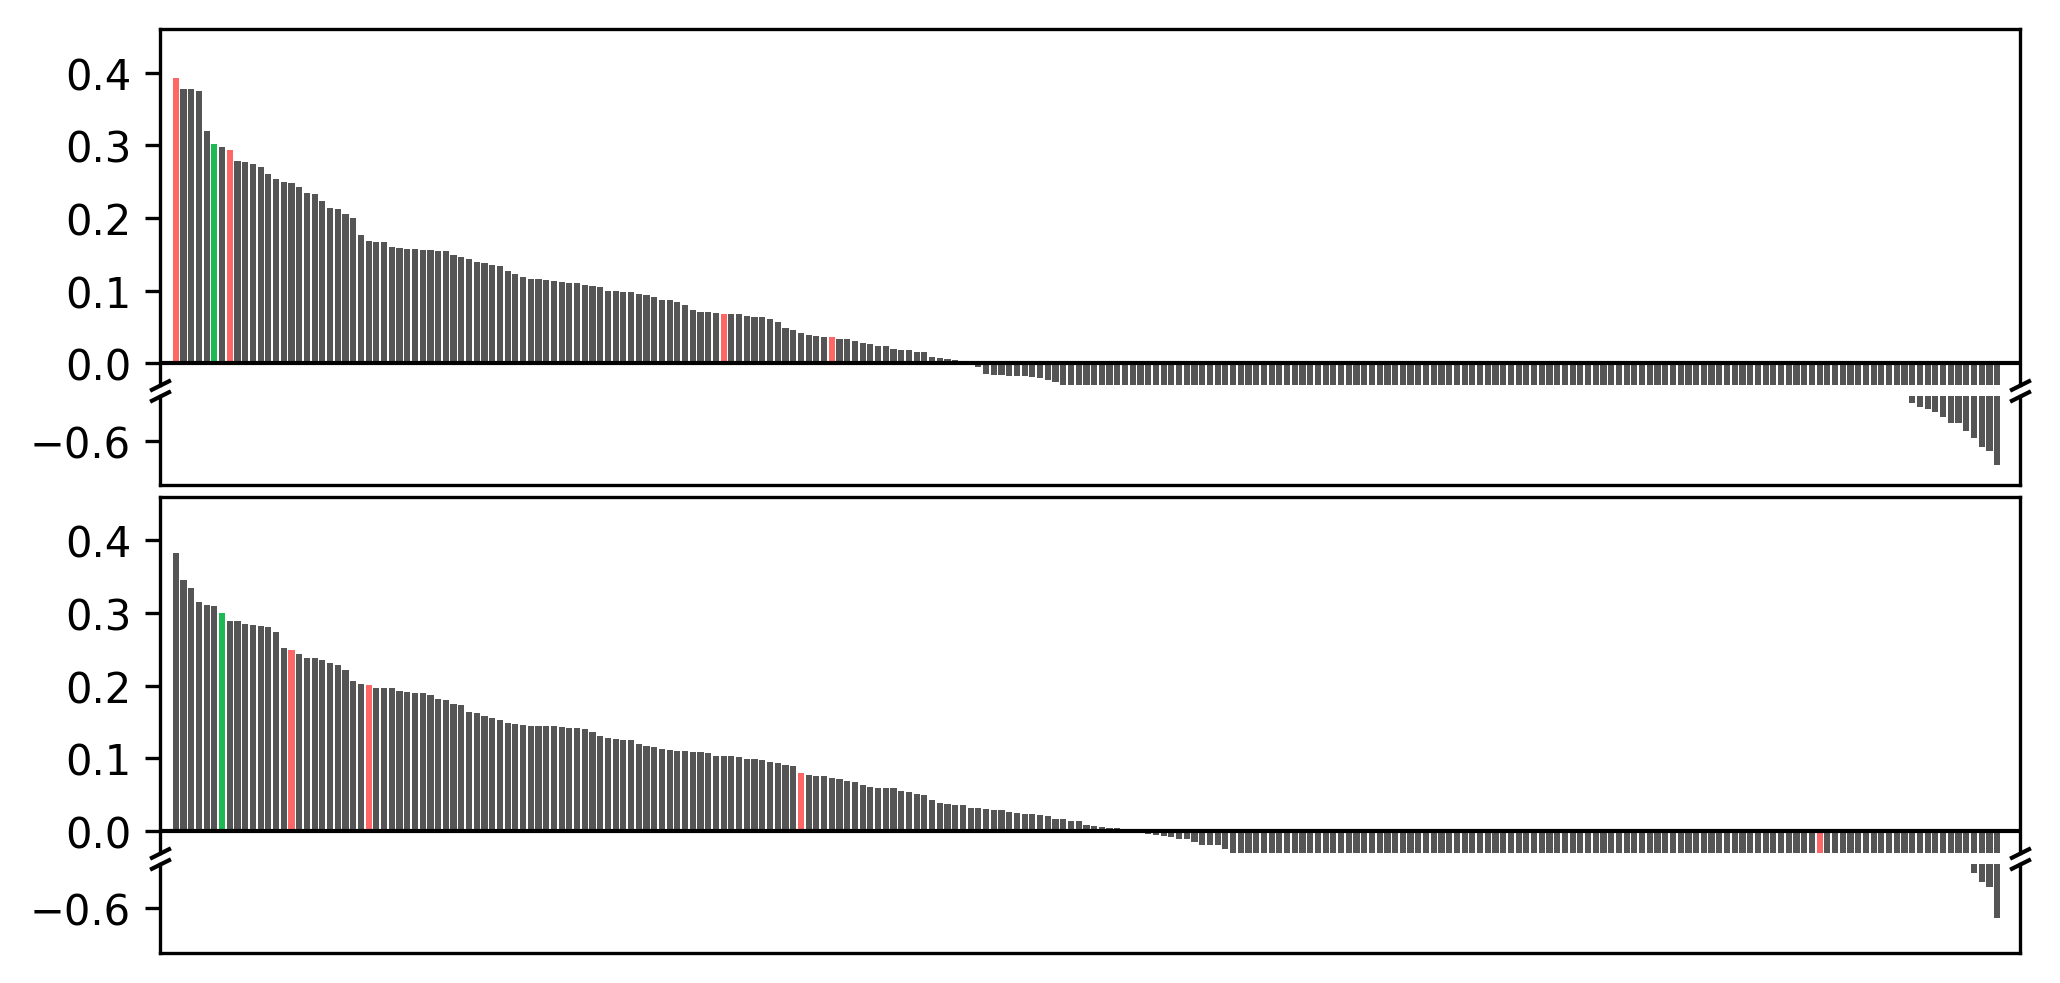

In [8]:
hippocampus_idx  =  [215, 216, 217, 218]
hippocampus_label = ['anterior-left','anterior-right','posterior-left','posterior-right']

plt.style.use('default')
fig, axes = plt.subplots(4,1,figsize=(8,4), dpi=300, sharex=True, gridspec_kw={'height_ratios':[4,1,4,1]})

# add the performance of the original model (use the whole hippocampus as a seed)
roi_performance_concat = np.vstack([roi_performance, np.array([0.30240669872419057, 0.2998089418135322])])

all_performance = []
color_list = []
for i in range(200):
    all_performance.append(roi_performance_concat[i,0])
    color_list.append('#555555')

for i in range(36):
    all_performance.append(roi_performance_concat[200+i,0])
    if i in [4,5,6,7]:
        print(200+i, roi_performance_concat[200+i,0])
        color_list.append('#ff6666')
    else:
        color_list.append('#555555')
all_performance.append(roi_performance_concat[-1,0])
color_list.append('#1db954')
roi_performance_sorted = np.sort(all_performance)[::-1]
roi_performance_argsorted = np.argsort(all_performance)[::-1]
color_sorted = np.array(color_list)[roi_performance_argsorted]
print(np.where(color_sorted=='#ff6666'))

axes[0].bar(np.arange(237), roi_performance_sorted,color=color_sorted, width=0.8)
axes[1].bar(np.arange(237), roi_performance_sorted,color=color_sorted, width=0.8)
axes[0].set_ylim(-0.03, 0.46)
axes[1].set_ylim(-0.7, -0.5)
axes[0].spines.bottom.set_visible(False)
axes[1].spines.top.set_visible(False)
axes[0].axhline(0.0, c='k', lw=1)
axes[0].set_xlim(-2, 237+2)
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=5,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
axes[0].plot([0, 1], [0, 0], transform=axes[0].transAxes, **kwargs)
axes[1].plot([0, 1], [1, 1], transform=axes[1].transAxes, **kwargs)
axes[1].set_yticks([-0.6])
all_performance = []
color_list = []
for i in range(200):
    all_performance.append(roi_performance_concat[i,1])
    color_list.append('#555555')

for i in range(36):
    all_performance.append(roi_performance_concat[200+i,1])
    if i in [4,5,6,7]:
        print(200+i, roi_performance_concat[200+i,1])
        color_list.append('#ff6666') # red color for the hippocampus sub-regions
    else:
        color_list.append('#555555')

all_performance.append(roi_performance_concat[-1,1])
color_list.append('#1db954') # green color for the whole hippocampus
roi_performance_sorted = np.sort(all_performance)[::-1]
roi_performance_argsorted = np.argsort(all_performance)[::-1]
color_sorted = np.array(color_list)[roi_performance_argsorted]
print(np.where(color_sorted=='#ff6666'))

axes[2].bar(np.arange(237), roi_performance_sorted, color=color_sorted, width=0.8)
axes[3].bar(np.arange(237), roi_performance_sorted, color=color_sorted, width=0.8)
axes[2].set_ylim(-0.03, 0.46)
axes[3].set_ylim(-0.7, -0.5)
axes[2].spines.bottom.set_visible(False)
axes[3].spines.top.set_visible(False)
axes[2].axhline(0.0, c='k', lw=1)
axes[2].plot([0, 1], [0, 0], transform=axes[2].transAxes, **kwargs)
axes[3].plot([0, 1], [1, 1], transform=axes[3].transAxes, **kwargs)
axes[3].set_yticks([-0.6])
axes[0].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[2].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
for ax in axes:
    ax.set_xticks([])
plt.subplots_adjust(hspace=0.05)